In [1]:
import ROOT as r
r.EnableImplicitMT()

from xgboost import XGBClassifier, plot_importance, cv, DMatrix
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import hist
from matplotlib import pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)

In [2]:
def load_data(signal_filename, background_filename):
    variables = ["VBSjet1pt", "VBSjet1eta", "VBSjet1phi", "VBSjet2pt", "VBSjet2eta", "VBSjet2phi", "VBSMjj", "VBSdetajj"]

    def pddf(filename, variables):
        data = r.RDataFrame("Events", filename).Filter("weight > 0").Filter("passCut7").AsNumpy(variables)
        return pd.DataFrame(data)
    
    x_sig = pddf(signal_filename, variables)
    x_bkg = pddf(background_filename, variables)

    x_sig["label"] = 1
    x_bkg["label"] = 0

    df = pd.concat([x_sig, x_bkg], ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [4]:
df = load_data("/ceph/cms/store/user/aaarora/output/sig.root", "/ceph/cms/store/user/aaarora/output/bkg.root")

X = df.drop(columns=["label"]).to_numpy()
y = df["label"].to_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
params = {
    "objective": "binary:logistic",
    "device": "cuda:1",
    "eval_metric": "auc",
    "tree_method": "approx",
    "scale_pos_weight": len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    "n_estimators": 400,
    "early_stopping_rounds": 20,
    "max_depth": 4,
    "min_child_weight": 1,
    "colsample_bytree": 1,
    "colsample_bylevel": 1,
    "max_delta_step": 0.5,
    "subsample": 0.9,
    "learning_rate": 0.1,
    "lambda": 1,
    "alpha": 1,
    "gamma": 1,
}

In [9]:
bdt = XGBClassifier(**params)

bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.86915
[1]	validation_0-auc:0.87973
[2]	validation_0-auc:0.88330
[3]	validation_0-auc:0.88623
[4]	validation_0-auc:0.88835
[5]	validation_0-auc:0.89114


[6]	validation_0-auc:0.89294
[7]	validation_0-auc:0.89685
[8]	validation_0-auc:0.89841
[9]	validation_0-auc:0.90334
[10]	validation_0-auc:0.90532
[11]	validation_0-auc:0.90791
[12]	validation_0-auc:0.90924
[13]	validation_0-auc:0.90943
[14]	validation_0-auc:0.90958
[15]	validation_0-auc:0.91414
[16]	validation_0-auc:0.91708
[17]	validation_0-auc:0.91845
[18]	validation_0-auc:0.91882
[19]	validation_0-auc:0.91983
[20]	validation_0-auc:0.92121
[21]	validation_0-auc:0.92139
[22]	validation_0-auc:0.92200
[23]	validation_0-auc:0.92328
[24]	validation_0-auc:0.92442
[25]	validation_0-auc:0.92510
[26]	validation_0-auc:0.92520
[27]	validation_0-auc:0.92537
[28]	validation_0-auc:0.92558
[29]	validation_0-auc:0.92634
[30]	validation_0-auc:0.92679
[31]	validation_0-auc:0.92747
[32]	validation_0-auc:0.92831
[33]	validation_0-auc:0.92871
[34]	validation_0-auc:0.92986
[35]	validation_0-auc:0.92988
[36]	validation_0-auc:0.93010
[37]	validation_0-auc:0.93060
[38]	validation_0-auc:0.93074
[39]	validatio

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              device='cuda:1', early_stopping_rounds=20,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.5, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, ...)

In [10]:
y_pred_test = bdt.predict_proba(X_test)[:, 1]
y_pred_train = bdt.predict_proba(X_train)[:, 1]

/home/users/aaarora/.miniforge/envs/ml/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:48:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1727634894600/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:1, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [11]:
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

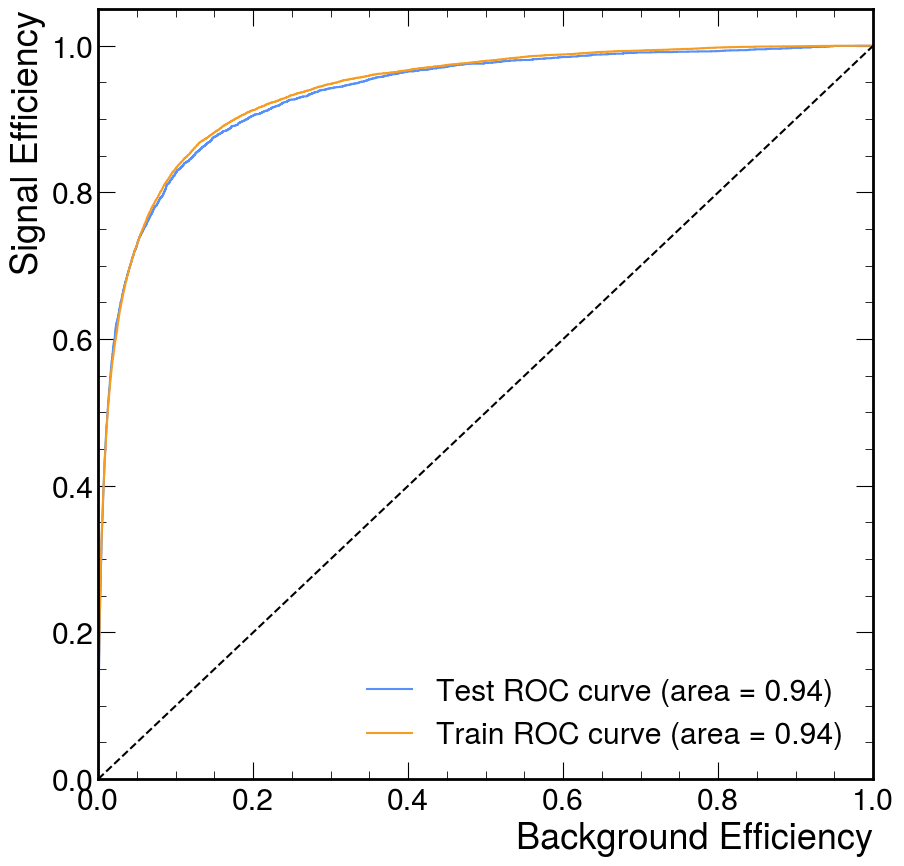

In [12]:
fig, ax = plt.subplots()
ax.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
ax.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Background Efficiency')
ax.set_ylabel('Signal Efficiency')
ax.legend()

[Text(0, 0, 'VBSjet1pt'),
 Text(0, 1, 'VBSjet1eta'),
 Text(0, 2, 'VBSjet1phi'),
 Text(0, 3, 'VBSjet2pt'),
 Text(0, 4, 'VBSjet2eta'),
 Text(0, 5, 'VBSjet2phi'),
 Text(0, 6, 'VBSMjj'),
 Text(0, 7, 'VBSdetajj')]

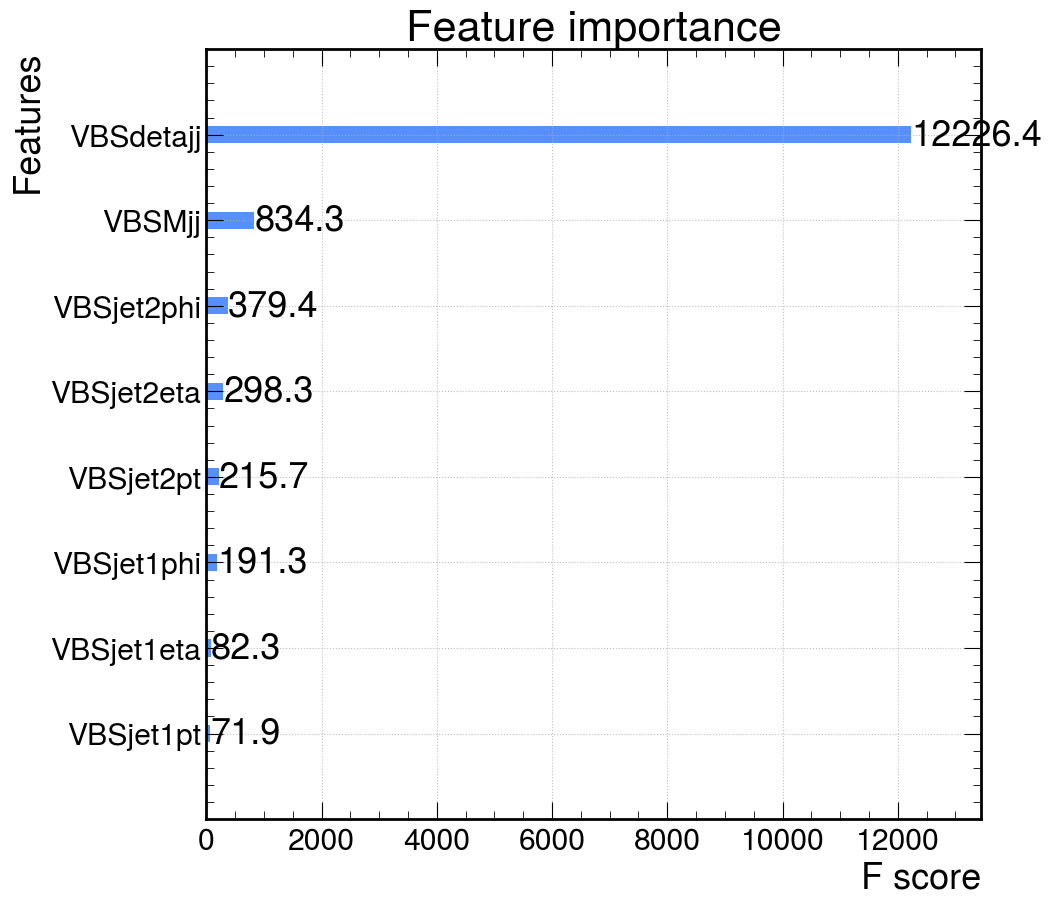

In [13]:
plot_importance(bdt, max_num_features=None, importance_type="gain", values_format="{v:.1f}").set_yticklabels(["VBSjet1pt", "VBSjet1eta", "VBSjet1phi", "VBSjet2pt", "VBSjet2eta", "VBSjet2phi", "VBSMjj", "VBSdetajj"])

In [14]:
r.TMVA.Experimental.SaveXGBoost(bdt, "VBSBDT", "BDT_Weights.root", num_inputs=X.shape[1])

# Validation

In [15]:
bdt = r.TMVA.Experimental.RBDT("VBSBDT", "BDT_Weights.root")

Text(0, 1, 'Density')

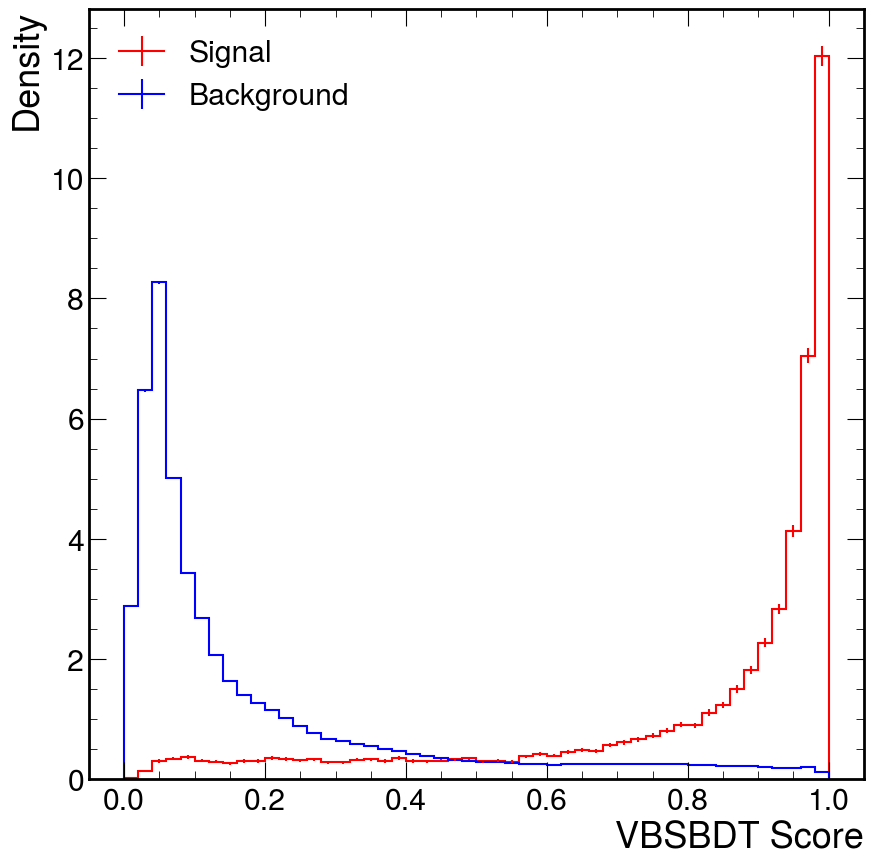

In [17]:
h1 = hist.Hist.new.Reg(50, 0, 1, name="SIG", label="SIG").Double()
h1.fill(bdt.Compute(X[y==1]).flatten())

h2 = hist.Hist.new.Reg(50, 0, 1, name="BKG", label="BKG").Double()
h2.fill(bdt.Compute(X[y==0]).flatten())

fig, ax = plt.subplots()
hep.histplot(h1, ax=ax, label="Signal", color="red", density=True)
hep.histplot(h2, ax=ax, label="Background", color="blue", density=True)

ax.legend()
ax.set_xlabel("VBSBDT Score")
ax.set_ylabel("Density")